# CIFAR10 Mosaic

Génération d'une image composée d'une mosaïque d'images de la même classe à partir d'une image sélectionné au hasard dans l'ensemble d'entraînement de la bibliothèque d'images [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

Récupération des données: exécuter le script `./datasets/get_datasets.sh`. Dans `datasets` faire `sh get_datasets.sh`

1. Réduction de chaque image de la classe à un vecteur (r,g,b) pour avoir un ensemble de tuiles. Chaque tuile est associée à une image de la classe choisie
2. Choix d'une image au hasard
3. Minimisation de la distance L2 entre chaque point de l'image et l'ensemble des tuiles de la classe choisie. Et on remplace chaque point par le numéro de la tuile en question dans l'ensemble d'entraînement.
4. Création d'une nouvelle image à partir des tuiles choisies

In [1]:
%matplotlib inline

# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Fonctions utilisées

In [2]:
from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
#import numpy as np
import os
import platform
import PIL.Image
from io import BytesIO
import IPython.display

# Pour le chargement des données

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    #Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr

# Pour l'affichage

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Chargement des données

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = './datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)


## Affichage de la première image de l'ensemble d'entraînement

(-0.5, 31.5, 31.5, -0.5)

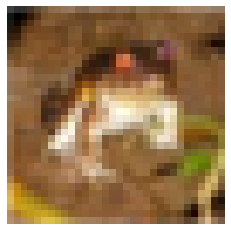

In [7]:
plt.imshow(X_train[0].astype('uint8'))
plt.axis('off')

In [36]:
X_train[0].astype('uint8')

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## Réduction de chaque image à un vecteur (r,g,b)

Pour chaque image: calcul de la somme des valeurs selon chaque couleur rgb.

In [41]:
# >>> Début de votre code
def blank_rgb(image):
    r,g,b,cc=0,0,0,0
    for i in image:
        for j in i:
            r+=j[0]
            g+=j[1]
            b+=j[2]
            cc+=1
    return np.array([r//cc,g//cc,b//cc])
#     Fin de votre code <<<

In [42]:
tmp = []
for i in X_train:
    tmp.append(blank_rgb(i))
X_reduced = np.array(tmp)

In [43]:
X_reduced

array([[141., 105.,  64.],
       [130., 130., 130.],
       [133., 135., 132.],
       ...,
       [ 82., 109., 122.],
       [162., 168., 177.],
       [138., 129., 127.]])

```
reduced data shape:  (50000, 3)
X_reduced[0] = array([144594., 107622.,  65574.])
```

## Image initiale

Choisir et afficher une image prise au hasard

In [44]:
img_select = X_train[152]

Visualisation avec les commandes précédentes

(-0.5, 31.5, 31.5, -0.5)

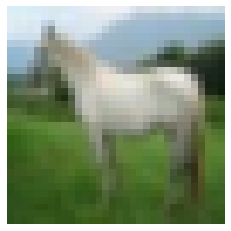

In [35]:
# >>> Début de votre code
plt.imshow(img_select.astype('uint8'))
plt.axis('off')
#     Fin de votre code <<<

Visualisation en taille réelle: `showarray(image)`

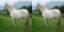

In [65]:
# >>> Début de votre code
showarray(np.concatenate([img_select,img_select],axis=1))
#     Fin de votre code <<<

Donner la classe de l'image sélectionnée

In [87]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# >>> Début de votre code
y_train[152]
#     Fin de votre code <<<

7

## Calcul de la distance L2

Pour chaque pixel de l'image choisie, minimisation de la distance L2 (distance Euclidienne classique) et création d'une matrice correspondante `X_mosaic` avec les indices des images sélectionnées.

In [81]:
X_mosaic = np.zeros((32,32))

import math

# On parcourt l'image en prenant en compte chaque canal de l'image choisie initialement
# Comparaison d'un pixel avec les images de la classe choisie
# Calcul de la distance euclidienne
# Récupération de l'indice de l'image correspondant à la plus petite distance

# >>> Début de votre code
def l2(k,x):
    return math.sqrt(((k[0]-x[0])**2)+((k[1]-x[1])**2)+((k[2]-x[2])**2))

def knn(k,data):
    tmp,w = None,None
    for i in range(len(data)):
        if l2(k,data[i])==0:
            pass
        else:
            if tmp == None:
                tmp = l2(k,data[i])
            else:
                if l2(k,data[i])<tmp:
                    tmp = l2(k,data[i])
                    w = i
    return w

def mosaic(image,redu):
    moz = []
    for i in image:
        tmp = []
        for j in i:
            tmp.append(knn(j,redu))
        moz.append(tmp.copy())
    return moz
            
#     Fin de votre code <<<

X_mosaic

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
ready = mosaic(img_select,X_reduced)

In [83]:
ready

[[32363,
  32363,
  32363,
  9985,
  9985,
  32363,
  9985,
  9985,
  9985,
  32363,
  32363,
  32363,
  20622,
  20242,
  48001,
  48001,
  48001,
  48001,
  10332,
  37788,
  15807,
  19094,
  33550,
  19094,
  49863,
  15807,
  37018,
  37018,
  19094,
  15807,
  33550,
  44806],
 [32363,
  32363,
  32363,
  32363,
  32363,
  32363,
  9985,
  9985,
  32363,
  32363,
  9985,
  32363,
  13861,
  26693,
  29759,
  10332,
  34783,
  37018,
  21248,
  1787,
  19637,
  4552,
  19027,
  33867,
  13334,
  20863,
  25212,
  29289,
  27571,
  27571,
  26629,
  27571],
 [32363,
  9985,
  32363,
  9985,
  9985,
  21440,
  14567,
  9985,
  9985,
  34783,
  34783,
  9985,
  9985,
  9985,
  15807,
  48074,
  19637,
  25212,
  5304,
  5304,
  4300,
  9597,
  24587,
  24587,
  24587,
  24587,
  13784,
  17850,
  687,
  20751,
  2107,
  34766],
 [32363,
  9985,
  9985,
  49863,
  9985,
  19269,
  35537,
  1522,
  15807,
  15807,
  49863,
  9985,
  9985,
  15807,
  13833,
  19027,
  25457,
  25457,
  

## Création et affichage de l'image finale

In [85]:
X_final = np.zeros((32*32, 32*32, 3))
# indices de la tuile dans X_mosaic
# Numéro de la tuile correspondante
# Alimentation de X_final avec les éléments de chaque tuile


# >>> Début de votre code
def drawing(code):
    draw = []
    for i in code:
        line = []
        for j in i:
            line.append(X_train[j])
        draw.append(np.concatenate(line,axis=1))
    return np.concatenate(draw)

X_final = drawing(ready)
        
#     Fin de votre code <<<

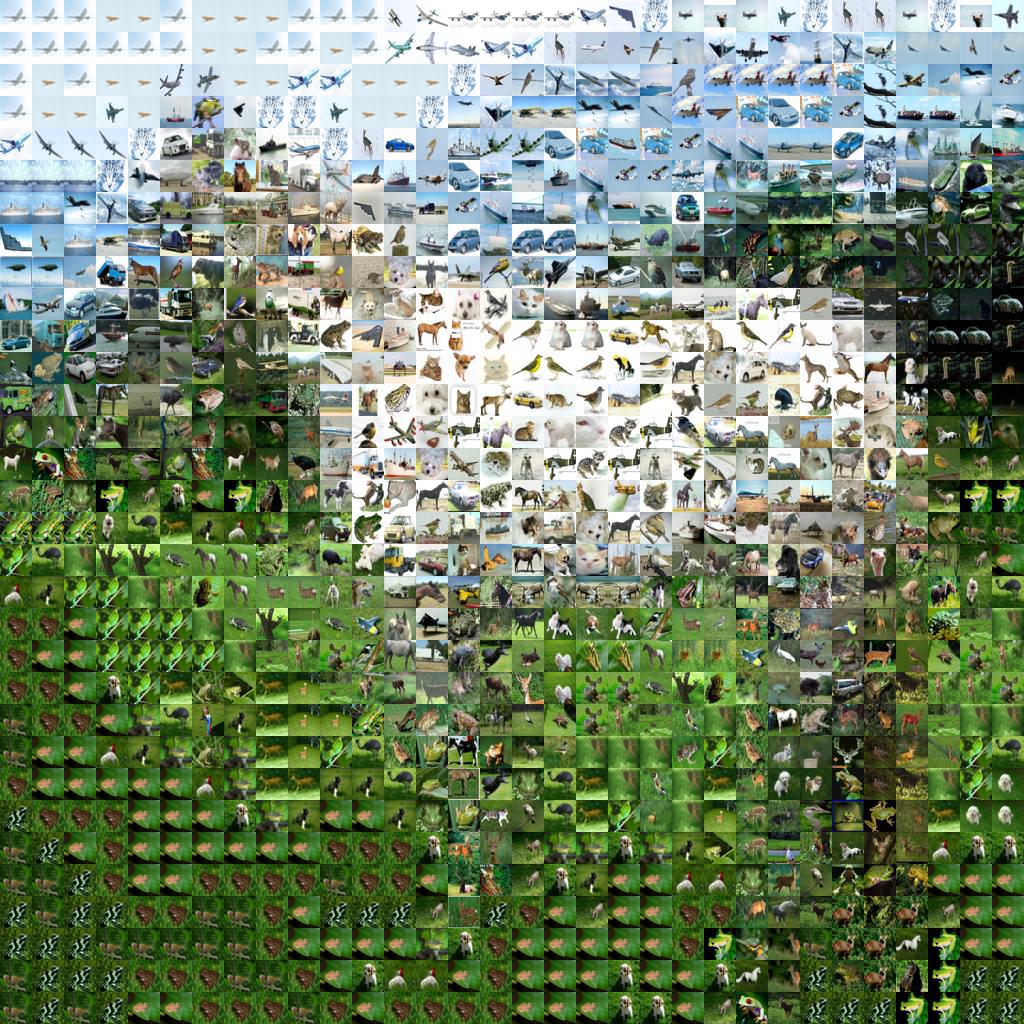

In [86]:
showarray(X_final)

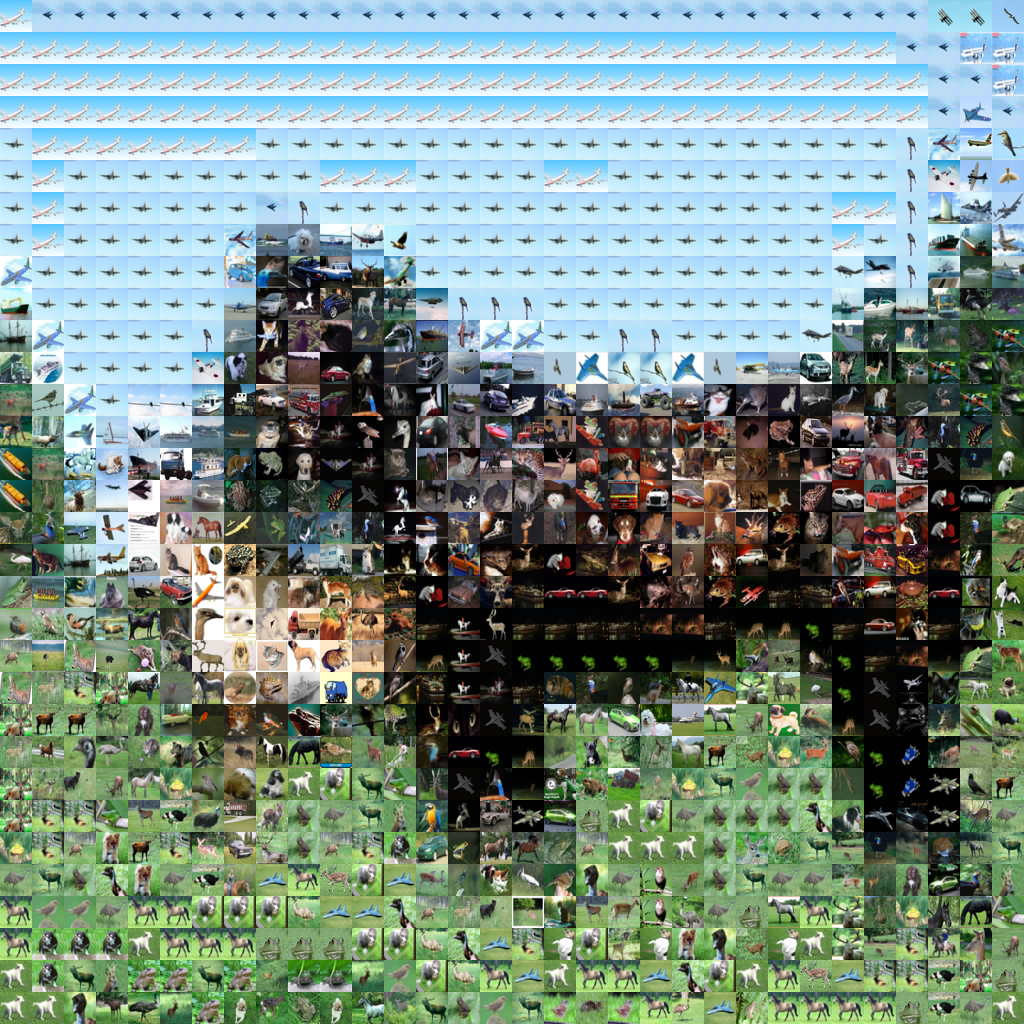

In [88]:
new_img = mosaic(X_train[12],X_reduced)
new_draw = drawing(new_img)
showarray(new_draw)